In [1]:
import os
import copy
import sys
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from PIL import Image
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchvision.models import resnet101, mobilenet_v2
from tqdm import tqdm

print(f'Torch version: {torch.__version__}')
print(f'Timm version: {timm.__version__}')

Torch version: 2.3.0+cu121
Timm version: 0.9.16


# Training configurations

In [2]:
dataset_dir = '../../datasets/rafdb/basic'
# backbone = 'enet_b0'
backbone = 'enet_b2'

In [3]:
batch_size = 32
epochs = 40
lr = 5e-5
gamma = 0.8
seed = 21520456
device = 'cuda'

training_type = 'full' # full or classifier
# training_type = 'classifier'
use_early_stopping = True
scheduler = ""

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [4]:
model_file_name = f'{backbone}_robust_{training_type}_{lr}_{epochs}_{"es" if use_early_stopping else "noes"}'
os.makedirs(f'./logs/{model_file_name}', exist_ok=True)

In [5]:
USE_ENET2 = True if 'b2' in backbone else False
IMG_SIZE = 260 if USE_ENET2 else 224


train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [6]:
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

# Helper classes

## Optimizer

In [7]:
class RobustOptimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, eps=0.05, **kwargs):
        defaults = dict(rho=eps, **kwargs)
        super(RobustOptimizer, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)
                self.state[p]["e_w"] = e_w

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.sub_(self.state[p]["e_w"])

        self.base_optimizer.step()

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        closure = torch.enable_grad()(closure)

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
            torch.stack([p.grad.norm(p=2).to(shared_device)
                            for group in self.param_groups for p in group["params"]
                            if p.grad is not None]),
            p=2
        )
        return norm

## Early Stopping

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EearlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...\n')
            torch.save(model.state_dict(), f'./logs/{model_file_name}/checkpoint.pt')
            self.val_loss_min = val_loss

## RAF-DB Dataloader

In [9]:
class RafDb(data.Dataset):
    def __init__(self, dataset_path, phase, cache_data=True, data_transforms=None, update_cache=False):
        self.phase = phase
        self.transforms = data_transforms
        self.dataset_path = dataset_path
        
        if cache_data:
            cache_path = os.path.join(dataset_path, f'rafdb_{phase}.csv')
            if os.path.exists(cache_path) and not update_cache:
                df = pd.read_csv(cache_path)
            else:
                df = self.load_data()
                df.to_csv(cache_path)   
        else:
            df = self.load_data()

        if phase == 'train':
            self.data = df[df['file_name'].str.startswith('train')]
        elif phase == 'test':
            self.data = df[df['file_name'].str.startswith('test')]
        else:
            raise TypeError(f"Invalid value for phase {phase}")
        
        self.file_paths = self.data.loc[:, 'file_path'].values
        self.labels = self.data.loc[:, 'label'].values - 1
        print(f'{phase} set: {len(self)} images')
            
    def load_data(self):
        df = pd.read_csv(os.path.join(self.dataset_path, 'EmoLabel', 'list_patition_label.txt'), sep=' ', header=None, names=['file_name', 'label'])
        file_names = df.loc[:, 'file_name'].values
        file_paths = []
        for f in file_names:
            f = f.split(".")[0]
            f += '_aligned.jpg'
            path = os.path.join(self.dataset_path, 'Image', 'aligned', f)
            file_paths.append(path)
        
        df['file_path'] = file_paths
        return df
    
    def get_weights(self):
        sample_label, sample_counts = np.unique(self.labels, return_counts=True)
        cw = 1/sample_counts
        cw /= cw.min()
        class_weights = {i:cwi for i, cwi in zip(sample_label, cw)}
        return class_weights
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.labels[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label

In [10]:
class EmotionLabel:
    def __init__(self):
        self.labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
        self.index_to_label = {index: label for index, label in enumerate(self.labels)} 
        self.label_to_index = {label: index for index, label in enumerate(self.labels)}
        
    def get_index(self, label):
        return self.label_to_index.get(label, None)
    
    def get_label(self, index):
        return self.index_to_label.get(index, None)

In [11]:
train_set = RafDb(dataset_dir, 'train', data_transforms=train_transforms, update_cache=True)
val_set = RafDb(dataset_dir, 'test', data_transforms=test_transforms, update_cache=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, **kwargs)

train set: 12271 images
test set: 3068 images


In [12]:
mapper = EmotionLabel()

class_weights = train_set.get_weights()
for label_idx, weight in class_weights.items():
    print(f'{mapper.get_label(label_idx)}: {weight:.2f}')

Surprise: 3.70
Fear: 16.98
Disgust: 6.66
Happiness: 1.00
Sadness: 2.41
Anger: 6.77
Neutral: 1.89


# Main functions

In [13]:
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

## Loss function

In [14]:
weights = torch.FloatTensor(list(class_weights.values())).cuda()

def label_smooth(target, n_classes: int, label_smoothing=0.1):
    # One-hot encoding
    batch_size = target.size(0)
    target = torch.unsqueeze(target, 1)
    soft_target = torch.zeros((batch_size, n_classes), device=target.device)
    soft_target.scatter_(1, target, 1)
    # Label smoothing
    soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
    return soft_target

def cross_entropy_loss_with_soft_target(pred, soft_target):
    return torch.mean(torch.sum(-weights * soft_target * torch.nn.functional.log_softmax(pred, -1), 1))

def cross_entropy_with_label_smoothing(pred, target):
    soft_target = label_smooth(target, pred.size(1))
    return cross_entropy_loss_with_soft_target(pred, soft_target)

criterion = cross_entropy_with_label_smoothing

## Model training function

In [15]:
def train(model, n_epochs=epochs, learning_rate=lr, robust=False):
    if use_early_stopping:
        early_stopping = EarlyStopping(patience=5, verbose=True)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learning_rate)
    else:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        
    # scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    
    best_acc = 0
    best_model = None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_acc = 0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            if robust:
                # optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
                # second forward-backward pass
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            acc = (output.argmax(dim=1) == label).float().sum()
            epoch_acc += acc
            epoch_loss += loss
        epoch_acc /= len(train_set)
        epoch_loss /= len(train_set)
        
        model.eval()
        with torch.no_grad():
            epoch_val_acc = 0
            epoch_val_loss = 0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output, label)
                
                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_acc += acc
                epoch_val_loss += val_loss
        epoch_val_acc /= len(val_set)
        epoch_val_loss /= len(val_set)
        
        # save scores for each epoch
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        
        print(f"Epoch: {epoch + 1} - loss: {epoch_loss:.4f} - acc: {epoch_acc: .4f} - val_loss: {epoch_val_loss: .4f} - val_acc: {epoch_val_acc: .4f}\n")
        
        if best_acc < epoch_val_acc:
            best_acc = epoch_val_acc
            best_model = copy.deepcopy(model.state_dict())

        if use_early_stopping:
            early_stopping(epoch_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # scheduler.step()
        
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best accuracy: {best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_acc = 0
            epoch_val_loss = 0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output, label)
                
                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_acc += acc
                epoch_val_loss += val_loss
        epoch_val_acc /= len(val_set)
        epoch_val_loss /= len(val_set)
        
        print(f"val_loss: {epoch_val_loss: .4f} - val_acc: {epoch_val_acc: .4f}\n")
    else:
        print(f"No best model. Best accuracy so far: {best_acc}")
        
    # return the state dict of the model with highest val acc along with the loss and accuracy history
    return best_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Model Training

In [16]:
if USE_ENET2:
    model = timm.create_model('tf_efficientnet_b2.ns_jft_in1k', pretrained=False)
    model.classifier = torch.nn.Identity()
    model.load_state_dict(torch.load('../../models/pretrained_faces/vggface2_enet2.pt'))
else:
    model = timm.create_model('tf_efficientnet_b0.ns_jft_in1k', pretrained=False)
    model.classifier = torch.nn.Identity()
    model.load_state_dict(torch.load('../../models/pretrained_faces/vggface2_enet0.pt'))

In [17]:
num_classes = len(mapper.labels)
if USE_ENET2:
    model.classifier = nn.Sequential(nn.Linear(in_features=1408, out_features=num_classes)) #1792 #1280 #1536
else:
    model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=num_classes))
# model.head.fc=nn.Linear(in_features=3072, out_features=num_classes)
# model.head=nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
model = model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [ ]:
if training_type == 'full':
    set_parameter_requires_grad(model, requires_grad=True)
elif training_type == 'classifier':
    set_parameter_requires_grad(model, requires_grad=False)
    set_parameter_requires_grad(model.classifier, requires_grad=True)

# best_model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(model, epochs, lr, robust=True)
best_model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(model, 2, 8e-5, robust=True)

  1%|▌                                                                                               | 2/384 [01:35<4:49:48, 45.52s/it]

In [19]:
# Save loss and accuracy histories
history = {
    'train_loss': [item.detach().cpu().numpy() for item in train_loss_hist],
    'train_acc': [item.detach().cpu().numpy() for item in train_acc_hist],
    'val_loss': [item.detach().cpu().numpy() for item in val_loss_hist],
    'val_acc': [item.detach().cpu().numpy() for item in val_acc_hist],
}

with open(f'./logs/{model_file_name}/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [20]:
# Save the trained model
PATH = f'../../models/raf/{model_file_name}.pt'
torch.save(model, PATH)

# Model evaluation

In [21]:
print(PATH)
model = torch.load(PATH)
model = model.eval()

../../models/raf/enet_b0_robust_full_5e-05_40_es.pt


In [22]:
y_val, y_scores_val = [], []
model.eval()

for image, label in val_set:
    image.unsqueeze_(0)
    image = image.cuda()
    scores = model(image)
    scores = scores[0].data.cpu().numpy()
    y_scores_val.append(scores)
    y_val.append(label)

y_scores_val = np.array(y_scores_val)
y_val = np.array(y_val)
print(y_scores_val.shape, y_val.shape)

(3068, 7) (3068,)


## Accuracies

In [23]:
y_pred = np.argmax(y_scores_val, axis=1)
accuracy = 100.0 * (y_val == y_pred).sum() / len(y_val)
print(f"Validation accuracy: {accuracy}")

y_train = np.array(train_set.labels)

for i in range(y_scores_val.shape[1]):
    _val_acc = (y_pred[y_val == i] == i).sum() / (y_val == i).sum()
    print('%s (%d/%d) -- Accuracy: %f' %(mapper.get_label(i), (y_train == i).sum(), (y_val == i).sum(), (100 * _val_acc)))

Validation accuracy: 77.41199478487614
Surprise (1290/329) -- Accuracy: 89.969605
Fear (281/74) -- Accuracy: 78.378378
Disgust (717/160) -- Accuracy: 81.250000
Happiness (4772/1185) -- Accuracy: 77.552743
Sadness (1982/478) -- Accuracy: 74.476987
Anger (705/162) -- Accuracy: 85.802469
Neutral (2524/680) -- Accuracy: 70.147059


In [24]:
labels = list(mapper.labels)
print(labels)
print(y_pred.shape, y_val.shape, (y_pred == y_val).mean())

['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
(3068,) (3068,) 0.7741199478487614


## Precision, Recall and F1 Score

In [25]:
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}')

Precision: 0.68
Recall: 0.80
F1 Score: 0.71


## Learning curve

In [26]:
def plot_training_history(history):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_loss'], color='blue', label='Train Loss')
    ax1.plot(history['val_loss'], color='green', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], color='blue', label='Train Accuracy')
    ax2.plot(history['val_acc'], color='green', label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

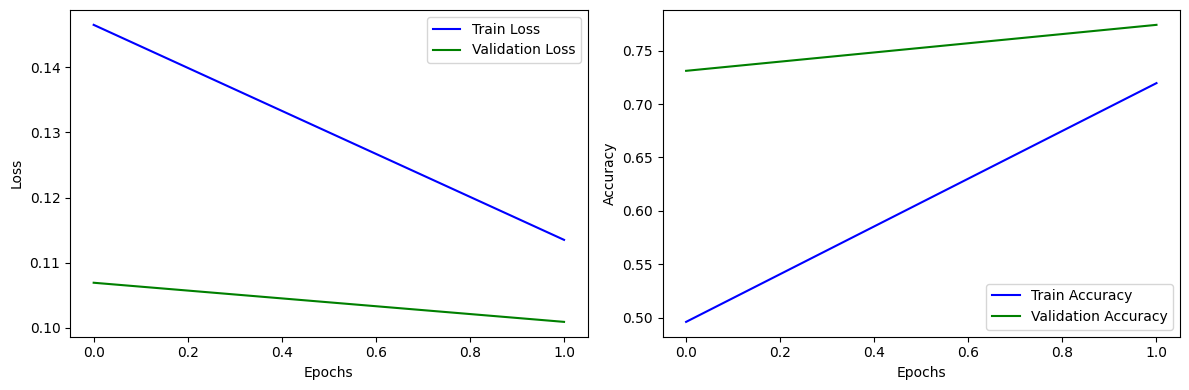

In [27]:
with open(f'./logs/{model_file_name}/training_history.pkl', 'rb') as f:
    history = pickle.load(f)
plot_training_history(history)

## Confusion matrix

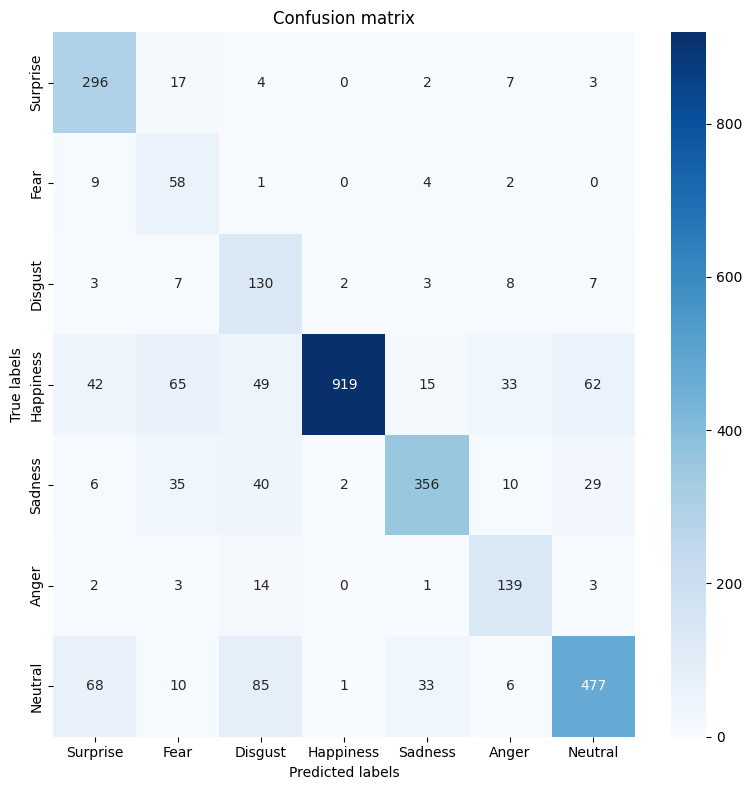

In [28]:
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.tight_layout()
plt.show()